In [164]:
%reset -f

In [165]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
plt.style.use('classic')
%matplotlib inline

In [166]:
# Model parameters
parameters=pd.Series(dtype='float64')
parameters['β']=0.98 # discount rate : standard
parameters['γ']=2 # risk aversion : standard
parameters['η']=0.83 # Elasticity of substitution (tradable vs nontradable) : conservative (Bianchi,2011)
parameters['ξ']=1.5 # Elasticity of substitution (domestic tradable vs import) : standard 
parameters['σ']=6 # Elasticity of substitution (differentiated varieties) : standard
parameters['ν']=0.012 # bond adjustment cost : target 10% of GDP in ss
#parameters['P_T']=1 # tradable price index (numeraire)
parameters['P_TI']=1# import price index (exogenous numeraire) 
parameters['ω']=0.9999 # weight on tradables : target 50% tradable share in consumption (Lombardo and Ravenna, 2012)
parameters['L']=1 # labor supply

parameters['k']=1/1.67+parameters['σ']-1  # shape parameter of Pareto : target 1.67 log US plant sales sd
parameters['a_min']=1 # lower bound of Pareto

parameters['μ']=0.6 # foreign input share of export fixed cost (Chaney 2016, 0.5~0.7)
parameters['F_x']=0.0032 # export fixed cost : target 21% exporting firms in US
parameters['F_e']=1 # entry cost
parameters['ψ']=0.025 # probability of firm exit : US data, 10 percent job destruction per year)
parameters['κ']=0.1 # development of financial market (benchmark=1)
parameters['τ']=1.3 # iceberg trade cost : standard (Obstfeld and Rogoff, 2001)

parameters['Ε']=1 # Nominal exchange rate
parameters['P_star']=1 # foreign price index
parameters['w_star']=10 # foreign wage : arbitrary
parameters['W_star']=11 # foreign nominal wage
parameters['r_star']=0.04 # foreign bond return : standard
parameters['A_star']=1 # foreign technology
#parameters['P_T_star']=1 # foreign tradable price index
#parameters['P_TI_star']=5 # foreign imported tradable price index
#parameters['E_star']=200 # foreign consumption expenditure

parameters['ρ_A']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_A']=0.00852 # technology standard deviation (BKK, 1992)
parameters['ρ_P_star']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_P_star']=0.00852 # technology standard deviation (BKK, 1992)
parameters['ρ_A_star']=0.906 # technology AR(1) coefficient (BKK, 1992)
parameters['σ_A_star']=0.00852 # technology standard deviation (BKK, 1992)

parameters['Y_N']=10 # nontradable endowment :arbitrary
parameters['q_f_res']=5 # foreign demand
parameters['q_f_res_star']=5  #q_f_res=(parameters.P_star**(parameters.σ-1))*parameters.q_f_res
# parameters['w']=5 # wage
# parameters['M_d']=1

In [167]:
def G(a):
    m=1-(parameters.a_min/a)**parameters.k
    if m<0:
        return 0
    else:
        return m

def equilibrium_equations(variables_forward, variables_current, parameters):
    # parameters
    p=parameters
    
    # Pareto    
    θ=(p.k/(p.k-(p.σ-1)))**(1/(p.σ-1))     #parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(parameters.σ/(parameters.σ-1))
    a_tilde_d=θ*p.a_min
    
    # variables
    fwd=variables_forward
    cur=variables_current
    
    C_N=p.Y_N
    
    # Tradable price definition
    cur_P_T=(p.P_TI**(1-p.ξ)+cur.P_TD**(1-p.ξ))**(1/(1-p.ξ))
    fwd_P_T=(p.P_TI**(1-p.ξ)+fwd.P_TD**(1-p.ξ))**(1/(1-p.ξ))
    
    # Price definition
    cur_P=(((p.ω**p.η)*(cur_P_T**(1-p.η)))+(((1-p.ω)**p.η)*(cur.P_N**(1-p.η))))**(1/(1-p.η))
    fwd_P=(((p.ω**p.η)*(fwd_P_T**(1-p.η)))+(((1-p.ω)**p.η)*(fwd.P_N**(1-p.η))))**(1/(1-p.η))
    
    # Consumption definition
    cur_C=(p.ω*(cur.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))
    fwd_C=(p.ω*(fwd.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))
    

    # Functions
    
    def p_d(a):
        return (p.σ/(p.σ-1))*((cur_P*cur.w)/(cur.A*a))
    
        #(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d))
        
    def p_x(a):
        return p.τ*(p.σ/(p.σ-1))*((cur_P*cur.w)/(cur.A*a))
        
        #parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d))
        
    def q_d(a):
        return (p.ω**(p.η))*((p_d(a)/cur_P)**(-p.σ))*((cur_P_T/cur_P)**(p.ξ-p.η))*((cur.P_TD/cur_P)**(p.σ-p.ξ))*cur_C
        
        #(parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']
        
    def q_x(a):
        return (p_x(a)**(-p.σ))*((cur.P_star**(p.σ-1))*parameters.q_f_res_star)
    
        #((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))**(-parameters.σ))*parameters.q_f_res
        
    def d_d(a):
        return (p_d(a)*(q_d(a)))/p.σ
        
        #(((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))*((parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']))/parameters.σ
        
    def d_x(a):
        return (p_x(a)*(q_x(a)))/p.σ-((1-p.μ)*(cur_P*cur.w*p.F_x)/cur.A+(p.μ*cur.P_star*p.w_star*p.F_x*p.Ε)/cur.A_star)
        
        #((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))*(((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*a_tilde_d)))**(-parameters.σ))*parameters.q_f_res))/parameters.σ-((1-parameters.μ)*(check['P']*rbc.ss.w*parameters.F_x)/rbc.ss.A+(parameters.μ*parameters.P_star*parameters.w_star*parameters.F_x*parameters.Ε)/parameters.A_star)
    #------------------------------------------Eq conditions
    
    # Budget Constraint
    budget_constraint=(cur_P*cur.w*p.L+(1+p.r_star)*cur_P_T*cur.B+(cur.v_tilde+cur.d_tilde)*cur.M_d+cur.P_N*p.Y_N+cur.TR
                        -(cur.P_N*C_N+cur_P_T*cur.C_T+cur_P_T*fwd.B+cur.v_tilde*(cur.M_d+cur.M_e)+(p.ν/2)*cur_P_T*(fwd.B**2)))
    
    # Euler equation (bond)
    euler_bond=p.β*(cur_P/fwd_P)*(fwd_P_T/cur_P_T)*((fwd_C/cur_C)**(-p.γ))*(1+p.r_star)-(1+p.ν*fwd.B)
    
    # Euler equation (mutual fund)
    euler_mutual=p.β*(1-p.ψ)*(cur_P/fwd_P)*((fwd_C/cur_C)**(-p.γ))*(fwd.v_tilde+fwd.d_tilde)-cur.v_tilde
    
    # Nontradable clearing
    nontradable_clearing=((1-p.ω)**p.η)*((cur.P_N/cur_P)**(-p.η))*cur_C-C_N
    
    # Free entry
    free_entry=cur.v_tilde-(cur_P*cur.w*p.F_e)/cur.A
    
    # Labor clearing
    labor_clearing=cur.M_d*(q_d(a_tilde_d)/(cur.A*a_tilde_d))+(cur.M_e*p.F_e/cur.A)+(1-G(cur.a_bar_x))*cur.M_d*(((p.τ*q_x(cur.a_tilde_x))/(cur.A*cur.a_tilde_x))+((1-p.μ)*p.F_x/cur.A))-p.L
    
    # Export cutoff
    cutoff_export=d_x(cur.a_bar_x)-((1-p.κ)/p.κ)*((1-p.μ)*(cur_P*cur.w*p.F_x)/cur.A+(p.μ*cur.P_star*p.w_star*p.F_x*p.Ε)/cur.A_star)
    
    # Financial constraint cutoff
    cutoff_constrained=d_x(cur.a_bar_f)
    
    # Average productivity of exporter
    avg_prod_export=θ*np.max([1,cur.a_bar_x])-cur.a_tilde_x
    
    # Average profit total
    avg_profit_total=d_d(a_tilde_d)+(1-G(cur.a_bar_x))*d_x(cur.a_tilde_x)-cur.d_tilde
    
    # Evolution of mass
    evol_mass=(1-p.ψ)*(cur.M_d+cur.M_e)-fwd.M_d
    
    # Domestic tradable price
    price_domestic=(cur.M_d**(1/(1-p.σ)))*p_d(a_tilde_d)-cur.P_TD
    
    # Technology process
    technology_proc=cur.A**p.ρ_A-fwd.A
    
    # Foreign Technology process
    foreign_tech_proc=cur.A_star**p.ρ_A-fwd.A_star
    
    # P_star process
    FX_proc=cur.P_star**p.ρ_P_star-fwd.P_star

    # Extensive margin
    extensive_margin=1-G(cur.a_bar_x)-cur.EM
    
    # Transfer
    transfer=(p.ν/2)*cur_P_T*(fwd.B**2)-cur.TR
    
    #---------------------------------------------------------------
     
    # Tradable price definition    
    price_T_def=(p.P_TI**(1-p.ξ)+cur.P_TD**(1-p.ξ))**(1/(1-p.ξ))-cur.P_T
    
    # Price definition
    price_def=(((p.ω**p.η)*(cur.P_T**(1-p.η)))+(((1-p.ω)**p.η)*(cur.P_N**(1-p.η))))**(1/(1-p.η))-cur.P
    
    # Consumption definition
    consumption_def=(p.ω*(cur.C_T**((p.η-1)/p.η))+(1-p.ω)*(C_N**((p.η-1)/p.η)))**(p.η/(p.η-1))-cur.C
    
    # Average domestic profit
    avg_profit_dom=d_d(a_tilde_d)-cur.d_tilde_d
    
    # Average export profit
    avg_profit_export=d_x(cur.a_tilde_x)-cur.d_tilde_x
    
    # Mass of exporters
    mass_exporter=(1-G(cur.a_bar_x))*cur.M_d-cur.M_x
    
    # Import
    Import=p.P_TI*cur.C_T*((cur.P_T/cur.P)**(p.ξ))*((p.P_TI/cur.P)**(-p.ξ))-cur.I
    
    # Export price
    price_export=(cur.M_x**(1/(1-p.σ)))*p_x(cur.a_tilde_x)-cur.P_x
    
    # Export
    export=cur.P_x*(cur.M_x**(p.σ/(p.σ-1)))*q_x(cur.a_tilde_x)-cur.X
    
    # Net export
    net_export=cur.X-cur.I-cur.NX
    
    # GDP
    output=cur.C*cur.P+cur.NX-cur.GDP
    
    # mass times profit
    mass_profit=cur.EM*cur.d_tilde_x-cur.exprof
    
    # PW/A
    effective_cost=(cur.P*cur.w)/cur.A-cur.EC
    
    # Intensive Margin (profit) of an average exporter
    #intensive_margin=d_x(2.097714)-cur.d_bar_x
    intensive_margin=d_x(3.226445)-cur.d_bar_x # ss in constrained
    
    #nominal wage
    nominal_wage=cur.P*cur.w-cur.W
    
    # Exchange Rate
    exchange_rate=cur.P_star/cur.P-cur.RER
    
    # Capital account
    capital_account=cur.P_T*fwd.B-(1+p.r_star)*cur.P_T*cur.B-cur.CA
    
    # Foreign cost
    foreign_cost=p.μ*cur.M_x*p.w_star*cur.P_star*p.F_x/cur.A_star-cur.FC
    
    # Stack eq conditions into a numpy array
    return np.array([
                euler_bond,
                budget_constraint,
                nontradable_clearing,
                euler_mutual,
                free_entry,
                labor_clearing,
                cutoff_constrained,
                cutoff_export,
                avg_prod_export,
                avg_profit_total,
                evol_mass,
                price_domestic,
                technology_proc,
                foreign_tech_proc,
                FX_proc,
                extensive_margin,
                transfer,
                foreign_cost
                #----------------------------
                 , price_T_def, price_def, consumption_def, avg_profit_dom, avg_profit_export, mass_exporter, Import, export, net_export, price_export, output, mass_profit, effective_cost, intensive_margin, nominal_wage, exchange_rate, capital_account
            ])

In [173]:
# Initialize the model
rbc=ls.model(equations=equilibrium_equations,
            n_states=5,
            var_names=['A','P_star', 'A_star', 'B','M_d','M_e','P_N','C_T','v_tilde','d_tilde','a_bar_x','a_tilde_x','a_bar_f','w','P_TD', 'EM', 'TR','FC' 
                        ,'P_T','P','C','d_tilde_d','d_tilde_x','M_x','I','P_x','X','NX','GDP', 'exprof', 'EC', 'RER', 'd_bar_x', 'W', 'CA'
                      ],
            shock_names=['e_A','e_P_star','e_A_star','e_B','e_M_d'],
            parameters=parameters)

In [174]:
guess=[1,1,1,1.6,3.84,0.09,0.00,7.41,1.69,0.07,2.01,3.15,1.27,6.8,0.99,0.01,0.00,0.00,0.24,0.24,7.41,0.04,1.97,0.07,0.92,1.4,0.9,-0.01,1.83,0.03,1.69,4.01,2.21,1.69,-0.01]
rbc.compute_ss(guess)
print(rbc.ss)


A            1.00
P_star       1.00
A_star       1.00
B            1.60
M_d          3.84
M_e          0.09
P_N          0.00
C_T          7.41
v_tilde      1.69
d_tilde      0.07
a_bar_x      2.01
a_tilde_x    3.15
a_bar_f      1.27
w            6.80
P_TD         0.99
EM           0.01
TR           0.00
FC           0.00
P_T          0.24
P            0.24
C            7.41
d_tilde_d    0.04
d_tilde_x    1.97
M_x          0.07
I            0.92
P_x          1.40
X            0.90
NX          -0.01
GDP          1.83
exprof       0.03
EC           1.69
RER          4.01
d_bar_x      2.21
W            1.69
CA          -0.01
dtype: float64


<ipython-input-167-4b2a55912dc9>:79: RuntimeWarning: divide by zero encountered in double_scalars
  nontradable_clearing=((1-p.ω)**p.η)*((cur.P_N/cur_P)**(-p.η))*cur_C-C_N


In [170]:
guess2=rbc.ss

AttributeError: 'model' object has no attribute 'ss'

In [171]:
rbc.compute_ss(guess2)
print(rbc.ss)
#1,1,1,1.6,3.84,0.09,0.00,7.41,1.69,0.07,2.01,3.15,1.27,6.8,0.99,0.01,0.00,0.00,0.24,0.24,7.41,0.04,1.97,0.07,0.92,1.4,0.9,-0.01,1.83,0.03,1.69,4.01,2.21,1.69,-0.01

NameError: name 'guess2' is not defined

In [135]:
# P, B, a_tilde_x, v_tilde, C etc...
check=pd.Series(dtype='float64')
check['P_T']=(parameters.P_TI**(1-parameters.ξ)+rbc.ss.P_TD**(1-parameters.ξ))**(1/(1-parameters.ξ))
check['P']=((parameters.ω**parameters.η)*(check['P_T']**(1-parameters.η))+((1-parameters.ω)**parameters.η)*(rbc.ss.P_N**(1-parameters.η)))**(1/(1-parameters.η))
check['C']=(parameters.ω*(rbc.ss.C_T**((parameters.η-1)/parameters.η))+(1-parameters.ω)*(parameters.Y_N**((parameters.η-1)/parameters.η)))**(parameters.η/(parameters.η-1))
check['d_tilde_d']=(((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*(parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(1/(parameters.σ-1))))))*((parameters.ω**(parameters.η))*((((parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*(parameters.a_min*(parameters.k/(parameters.k-(parameters.σ-1)))**(1/(parameters.σ-1))))))/check['P'])**(-parameters.σ))*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((rbc.ss.P_TD/check['P'])**(parameters.σ-parameters.ξ))*check['C']))/parameters.σ
check['d_tilde_x']=((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))*(((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))**(-parameters.σ))*((rbc.ss.P_star**(parameters.σ-1))*parameters.q_f_res_star)))/parameters.σ-((1-parameters.μ)*(check['P']*rbc.ss.w*parameters.F_x)/rbc.ss.A+(parameters.μ*rbc.ss.P_star*parameters.w_star*parameters.F_x*parameters.Ε)/rbc.ss.A_star)
check['M_x']=(1-G(rbc.ss.a_bar_x))*rbc.ss.M_d
check['r_x']=1-G(rbc.ss.a_bar_x)
check['I']=(parameters.ω**parameters.η)*check['C']*((check['P_T']/check['P'])**(parameters.ξ-parameters.η))*((parameters.P_TI/check['P'])**(-parameters.ξ))*parameters.P_TI
check['P_x']=(check['M_x']**(1/(1-parameters.σ)))*(parameters.σ/(parameters.σ-1))*parameters.τ*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x))
check['X']=check['P_x']*((check['M_x'])**(parameters.σ/(parameters.σ-1)))*((rbc.ss.P_star**(parameters.σ-1))*parameters.q_f_res_star)*((parameters.τ*(parameters.σ/(parameters.σ-1))*((check['P']*rbc.ss.w)/(rbc.ss.A*rbc.ss.a_tilde_x)))**(-parameters.σ))
check['NX']=check['X']-check['I']
check['GDP']=check['C']*check['P']+check['NX']
check['B']=(parameters.β*(1+parameters.r_star)-1)/parameters.ν
check['d_tilde']=check['d_tilde_d']+(1-G(rbc.ss.a_bar_x))*check['d_tilde_x']
check['P_TC_T']=check['P_T']*rbc.ss.C_T
check['P_TDC_TD+PTIC_TI']=rbc.ss.P_TD*rbc.ss.C_T*((check['P_T']/check['P'])**(parameters.ξ))*((rbc.ss.P_TD/check['P'])**(-parameters.ξ))+parameters.P_TI*rbc.ss.C_T*((check['P_T']/check['P'])**(parameters.ξ))*((parameters.P_TI/check['P'])**(-parameters.ξ))
check['PC']=check['P']*check['C']
check['P_TC_T+P_NC_N']=check['P_T']*rbc.ss.C_T+rbc.ss.P_N*parameters.Y_N
check['RER']=rbc.ss.P_star/rbc.ss.P 
check['CA-NX']=rbc.ss.B*rbc.ss.P_T-(1+parameters.r_star)*rbc.ss.P_T*rbc.ss.B-rbc.ss.NX
check['P_TD_C_TD']=rbc.ss.P_T*rbc.ss.C_T-rbc.ss.I
check['foreign_cost']=rbc.ss.M_x*parameters.μ*parameters.w_star*parameters.P_star*parameters.F_x/parameters.A_star
check['spending_T+X']=check['P_TD_C_TD']+rbc.ss.v_tilde*rbc.ss.M_e+rbc.ss.X
check['Y_T']=rbc.ss.W*parameters.L+rbc.ss.d_tilde*rbc.ss.M_d-rbc.ss.M_e*rbc.ss.W*parameters.F_e/rbc.ss.A+check['foreign_cost']
check['Y']=check['Y_T']+rbc.ss.P_N*parameters.Y_N
check['CA+FC']=rbc.ss.CA+rbc.ss.FC
check['NX']=rbc.ss.NX

In [136]:
check

P_T                 0.249322
P                   0.249338
C                   7.419522
d_tilde_d           0.040098
d_tilde_x           1.976935
M_x                 0.075826
r_x                 0.019697
I                   0.923641
P_x                 1.406267
X                   0.909140
NX                 -0.014501
GDP                 1.835466
B                   1.600000
d_tilde             0.079038
P_TC_T              1.849793
P_TDC_TD+PTIC_TI    1.849793
PC                  1.849967
P_TC_T+P_NC_N       1.849967
RER                 4.010624
CA-NX              -0.001456
P_TD_C_TD           0.926152
foreign_cost        0.001456
spending_T+X        2.002807
Y_T                 1.835292
Y                   1.835466
CA+FC              -0.014501
dtype: float64

In [145]:
rbc.check_ss()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


In [146]:
moments=pd.Series(dtype='float64')
moments['share_C_T']=(rbc.ss.C_T*check['P_T'])/(check['P']*check['C']) # target 0.32 (Bianchi,2011)
moments['proportion_exporter']=1-G(rbc.ss.a_bar_x) # target US data, 0.21 (Ghironi and Melitz, 2005)
moments['bond_GDP_ratio']=(rbc.ss.B*check['P_T'])/rbc.ss.GDP
moments['import_GDP_ratio']=check['I']/check['GDP'] # 30% Korea
moments['export_GDP_ratio']=check['X']/check['GDP'] # 27% Korea
moments['NX_GDP_ratio']=check['NX']/check['GDP']
moments['share_import_to_tradable']=check['I']/(rbc.ss.C_T*check['P_T'])
moments['tradable_GDP_ratio']=(rbc.ss.C_T*check['P_T'])/check['GDP']
moments['nontradable_GDP_ratio']=(rbc.ss.P_N*parameters.Y_N)/check['GDP']
moments['consumption_GDP_ratio']=(check['P']*check['C'])/check['GDP']
moments['CA+FC-NX']=rbc.ss.CA+rbc.ss.FC-rbc.ss.NX

In [147]:
moments

share_C_T                   9.999059e-01
proportion_exporter         1.969719e-02
bond_GDP_ratio              2.173368e-01
import_GDP_ratio            5.032185e-01
export_GDP_ratio            4.953182e-01
NX_GDP_ratio               -7.900293e-03
share_import_to_tradable    4.993211e-01
tradable_GDP_ratio          1.007805e+00
nontradable_GDP_ratio       9.481304e-05
consumption_GDP_ratio       1.007900e+00
CA+FC-NX                    1.858583e-14
dtype: float64

In [148]:
rbc.linear_approximation(rbc.ss)


print('The matrix A:\n\n',np.around(rbc.a,4),'\n\n')
print('The matrix B:\n\n',np.around(rbc.b,4))

The matrix A:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 


The matrix B:

 [[-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.     -0.    ]
 ...
 [-0.     -0.     -0.     ... -0.      1.     -0.    ]
 [-0.     -4.0106 -0.     ... -0.     -0.     -0.    ]
 [-0.     -0.     -0.     ... -0.     -0.      1.    ]]


In [149]:
rbc.solve_klein(rbc.a,rbc.b)

print('The matrix F:\n\n',np.around(rbc.f,4),'\n\n')
print('The matrix P:\n\n',np.around(rbc.p,4))

The matrix F:

 [[ 8.3480e-01 -1.2070e-01 -2.4000e-03  6.5200e-02 -1.0590e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 2.8149e+00  2.0430e+00  4.0100e-02  1.1310e-01  6.0590e-01]
 [ 3.8000e-03  1.2661e+00  2.4800e-02  3.7200e-02  2.1300e-02]
 [ 1.4700e-02  6.9400e-02  1.4000e-03 -4.0000e-03 -1.0300e-02]
 [ 4.6000e-03 -1.1920e-01 -3.3220e-01  4.5100e-02  2.5800e-02]
 [ 7.2000e-03 -1.8640e-01 -5.1950e-01  7.0500e-02  4.0300e-02]
 [ 2.9000e-03 -7.5200e-02 -2.0960e-01  2.8400e-02  1.6300e-02]
 [ 6.8137e+00  2.5353e+00  4.9700e-02  7.4400e-02  2.1960e-01]
 [ 2.2000e-03  7.4200e-01  1.4600e-02  2.1800e-02 -3.9200e-02]
 [-3.0000e-04  6.5000e-03  1.8200e-02 -2.5000e-03 -1.4000e-03]
 [-7.0000e-03  9.5000e-03  2.0000e-04  2.3000e-03  2.3000e-03]
 [-0.0000e+00  1.9000e-03 -1.0000e-04 -2.0000e-04  3.0000e-04]
 [ 3.0000e-04  9.3100e-02  1.8000e-03  2.7000e-03 -4.9000e-03]
 [ 3.0000e-04  9.3100e-02  1.8000e-03  2.7000e-03 -4.9000e-03]
 [ 2.8148e+00  2.0429e+00  4.0100e-02  

In [150]:
rbc.impulse(T=81,t0=1,shocks=[0.01,0.01,0.01,0.01,0.01],percent=True,diff=True)

print('Impulse responses to a 1 unit shock to A:\n\n',rbc.irs['e_A'].head())

Impulse responses to a 1 unit shock to A:

     e_A         A  P_star  A_star         B       M_d       M_e           P_N  \
0  0.00  0.000000     0.0     0.0  0.000000  0.000000  0.000000  0.000000e+00   
1  0.01  0.010000     0.0     0.0  0.000000  0.000000  0.008348  7.974516e-08   
2  0.00  0.009060     0.0     0.0 -0.014574  0.008139  0.005752  7.594946e-08   
3  0.00  0.008208     0.0     0.0 -0.016107  0.013544  0.004368  7.577215e-08   
4  0.00  0.007437     0.0     0.0 -0.012916  0.017464  0.003517  7.661345e-08   

        C_T   v_tilde  ...       P_x         X        NX       GDP    exprof  \
0  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.028149  0.000038  ...  0.000035 -0.000114 -0.003634  0.003406 -0.000005   
2  0.028786 -0.000334  ... -0.000905  0.002927 -0.000227  0.006377  0.000043   
3  0.029489 -0.000279  ... -0.001249  0.004038  0.000969  0.007518  0.000036   
4  0.030054 -0.000080  ... -0.001351  0.004366  0.001287  0.007897  0

In [151]:
rbc.irs['e_A']['A']

0     0.000000
1     0.010000
2     0.009060
3     0.008208
4     0.007437
        ...   
76    0.000006
77    0.000006
78    0.000005
79    0.000005
80    0.000004
Name: A, Length: 81, dtype: float64

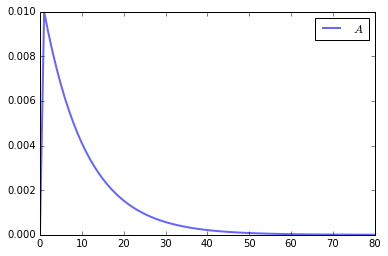

In [152]:
fig, plot_A_const = plt.subplots()
x = np.linspace(0, 80, 81)
plot_A_const.plot(x, rbc.irs['e_A']['A']/rbc.ss.A, linewidth=2, linestyle='solid', alpha=0.6, label='$A$')
plot_A_const.legend()
plt.savefig('plot_A_const.png')


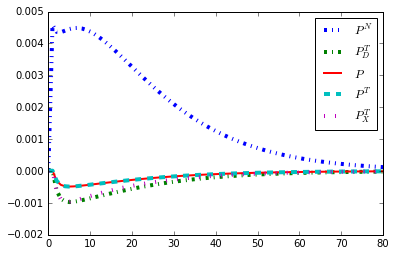

In [153]:
fig, PC_plot_P_nontr_const = plt.subplots()
PC_plot_P_nontr_const.plot(x, rbc.irs['e_A']['P_N']/rbc.ss.P_N, linewidth=4, linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha=1, label='$P^N$')
PC_plot_P_nontr_const.plot(x, rbc.irs['e_A']['P_TD']/rbc.ss.P_TD, linewidth=4, linestyle='dashdot', alpha=1, label='$P^T_D$')
PC_plot_P_nontr_const.plot(x, rbc.irs['e_A']['P']/rbc.ss.P, linewidth=2, linestyle='solid', alpha=1, label='$P$')
PC_plot_P_nontr_const.plot(x, rbc.irs['e_A']['P_T']/rbc.ss.P_T, linewidth=4, linestyle='dashed', alpha=1, label='$P^T$')
PC_plot_P_nontr_const.plot(x, rbc.irs['e_A']['P_x']/rbc.ss.P_x, linewidth=4, linestyle=(0, (1, 10)), alpha=1, label='$P_X^T$')
PC_plot_P_nontr_const.legend(loc='upper right')
axes = plt.gca()
axes.set_ylim([-0.002,0.005])
plt.savefig('PC_plot_P_nontr_const.png')

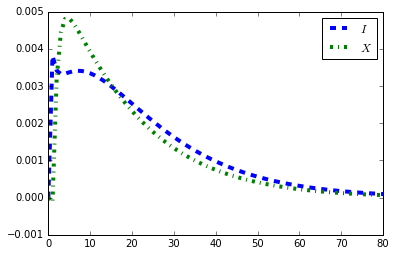

In [154]:
fig, PC_plot_NXIX_nontr_const = plt.subplots()
PC_plot_NXIX_nontr_const.plot(x, rbc.irs['e_A']['I']/rbc.ss.I, linewidth=4, linestyle='dashed', alpha=1, label='$I$')
PC_plot_NXIX_nontr_const.plot(x, rbc.irs['e_A']['X']/rbc.ss.X, linewidth=4, linestyle='dashdot', alpha=1, label='$X$')
PC_plot_NXIX_nontr_const.legend()
plt.savefig('PC_plot_NXIX_nontr_const.png')

In [155]:
fig, PC_plot_check = plt.subplots()
PC_plot_check.plot(x, rbc.irs['e_A']['NX'], linewidth=4, linestyle='dashed', alpha=1, label='$NX$')
PC_plot_check.plot(x, rbc.irs['e_A']['CA'], linewidth=4, linestyle='dashdot', alpha=1, label='$CA$')
plot_check.legend()

NameError: name 'plot_check' is not defined

In [156]:
fig, PC_plot_macro_nontr_const = plt.subplots()
PC_plot_macro_nontr_const.plot(x, rbc.irs['e_A']['C']/rbc.ss.C, linewidth=4, linestyle='dashed', alpha=1, label='$C$')
PC_plot_macro_nontr_const.plot(x, rbc.irs['e_A']['B']/rbc.ss.B, linewidth=4, linestyle='dashdot', alpha=1, label='$B$')
PC_plot_macro_nontr_const.plot(x, rbc.irs['e_A']['GDP']/rbc.ss.GDP, linewidth=2, linestyle='solid', alpha=1, label='$GDP$')
PC_plot_macro_nontr_const.legend(loc='lower right')
plt.savefig('PC_plot_macro_nontr_const.png')

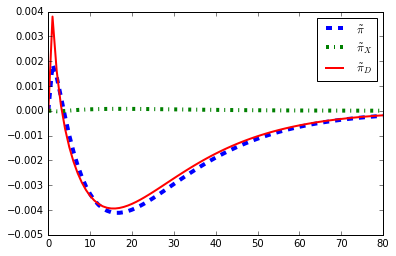

In [157]:
fig, PC_plot_d_nontr_const = plt.subplots()
PC_plot_d_nontr_const.plot(x, rbc.irs['e_A']['d_tilde']/rbc.ss.d_tilde, linewidth=4, linestyle='dashed', alpha=1, label=r'$\tilde{\pi}$')
PC_plot_d_nontr_const.plot(x, rbc.irs['e_A']['d_tilde_x']/rbc.ss.d_tilde_x, linewidth=4, linestyle='dashdot', alpha=1, label=r'$\tilde{\pi}_X$')
PC_plot_d_nontr_const.plot(x, rbc.irs['e_A']['d_tilde_d']/rbc.ss.d_tilde_d, linewidth=2, linestyle='solid', alpha=1, label=r'$\tilde{\pi}_D$')
PC_plot_d_nontr_const.legend(loc='upper right')
plt.savefig('PC_plot_d_nontr_const.png')

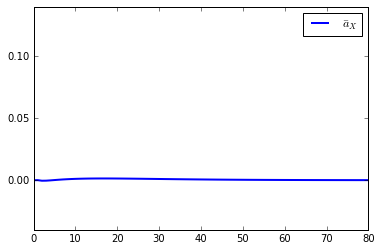

In [20]:
fig, plot_abar_const = plt.subplots()
plot_abar_const.plot(x, rbc.irs['e_A']['a_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{a}_X$')
plot_abar_const.legend()
axes = plt.gca()
axes.set_ylim([-0.04,0.14])
plt.savefig('plot_abar_const.png')

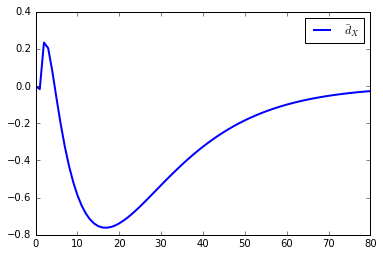

In [20]:
fig, plot_dbar_const = plt.subplots()
plot_dbar_const.plot(x, rbc.irs['e_A']['d_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{d}_X$')
plot_dbar_const.legend()
plt.savefig('plot_dbar_const.png')

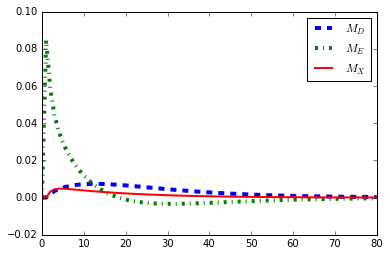

In [158]:
fig, PC_plot_M_nontr_const = plt.subplots()
PC_plot_M_nontr_const.plot(x, rbc.irs['e_A']['M_d']/rbc.ss.M_d, linewidth=4, linestyle='dashed', alpha=1, label=r'$M_D$')
PC_plot_M_nontr_const.plot(x, rbc.irs['e_A']['M_e']/rbc.ss.M_e, linewidth=4, linestyle='dashdot', alpha=1, label=r'$M_E$')
PC_plot_M_nontr_const.plot(x, rbc.irs['e_A']['M_x']/rbc.ss.M_x, linewidth=2, linestyle='solid', alpha=1, label=r'$M_X$')
PC_plot_M_nontr_const.legend()
plt.savefig('PC_plot_M_nontr_const.png')

In [159]:
fig, PC_plot_W_nontr_const = plt.subplots()
PC_plot_W_nontr_const.plot(x, rbc.irs['e_A']['W']/rbc.ss.W, linewidth=2, linestyle='solid', alpha=1, label=r'$W$')
PC_plot_W_nontr_const.legend()
plt.savefig('PC_plot_W_nontr_const.png')

In [160]:
fig, PC_plot_EC_nontr_const = plt.subplots()
PC_plot_EC_nontr_const.plot(x, rbc.irs['e_A']['EC']/rbc.ss.EC, linewidth=2, linestyle='solid', alpha=1, label=r'$W/A$')
PC_plot_EC_nontr_const.legend()
plt.savefig('PC_plot_EC_nontr_const.png')

In [161]:
#save responses
rbc.irs['e_A']['exprof']
np.savetxt("GDP_exprof_nontr_const.csv", rbc.irs['e_A']['exprof']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_A']['EM']
np.savetxt("EM_nontr_const.csv", rbc.irs['e_A']['EM'], delimiter=",", header='1')

rbc.irs['e_A']['d_bar_x']
np.savetxt("GDP_IM_nontr_const.csv", rbc.irs['e_A']['d_bar_x']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_A']['a_tilde_x']
np.savetxt("GDP_SE_nontr_const.csv", rbc.irs['e_A']['a_tilde_x']/1.217, delimiter=",", header='1')

In [162]:
rbc.irs['e_A']['exprof']
np.savetxt("PC_exprof_nontr_const.csv", rbc.irs['e_A']['exprof']/rbc.ss.exprof, delimiter=",", header='1')

rbc.irs['e_A']['EM']
np.savetxt("PC_EM_nontr_const.csv", rbc.irs['e_A']['EM']/rbc.ss.EM, delimiter=",", header='1')

rbc.irs['e_A']['d_bar_x']
np.savetxt("PC_IM_nontr_const.csv", rbc.irs['e_A']['d_bar_x']/rbc.ss.d_bar_x, delimiter=",", header='1')

rbc.irs['e_A']['a_tilde_x']
np.savetxt("PC_SE_nontr_const.csv", rbc.irs['e_A']['a_tilde_x']/rbc.ss.a_tilde_x, delimiter=",", header='1')

In [163]:
rbc.irs['e_A']['P_x']
np.savetxt("PC_P_x_nontr_const.csv", rbc.irs['e_A']['P_x']/rbc.ss.P_x, delimiter=",", header='1')

rbc.irs['e_A']['X']
np.savetxt("PC_X_nontr_const.csv", rbc.irs['e_A']['X']/rbc.ss.X, delimiter=",", header='1')

rbc.irs['e_A']['GDP']
np.savetxt("PC_GDP_nontr_const.csv", rbc.irs['e_A']['GDP']/rbc.ss.GDP, delimiter=",", header='1')

rbc.irs['e_A']['M_d']
np.savetxt("PC_M_d_nontr_const.csv", rbc.irs['e_A']['M_d']/rbc.ss.M_d, delimiter=",", header='1')

rbc.irs['e_A']['d_tilde']
np.savetxt("PC_d_tilde_nontr_const.csv", rbc.irs['e_A']['d_tilde']/rbc.ss.d_tilde, delimiter=",", header='1')

rbc.irs['e_A']['W']
np.savetxt("PC_W_nontr_const.csv", rbc.irs['e_A']['W']/rbc.ss.W, delimiter=",", header='1')

NameError: name 'df_P_x' is not defined

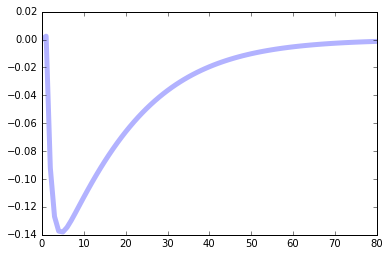

In [55]:
fig, plot_P_x = plt.subplots()
x = np.linspace(0, 80, 81)
plot_P_x.plot(x, rbc.irs['e_A']['P_x'], linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
plot_P_x.plot(x, df_P_x, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
plot_P_x.legend()
axes = plt.gca()
axes.set_ylim([-2,0])
plt.savefig('plot_P_x.png')

fig, plot_NX = plt.subplots()
x = np.linspace(0, 80, 81)
plot_NX.plot(x, rbc.irs['e_A']['NX'], linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
plot_NX.plot(x, df_NX, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
plot_NX.legend()
axes = plt.gca()
axes.set_ylim([0,9])
plt.savefig('plot_NX.png')

fig, plot_GDP = plt.subplots()
x = np.linspace(0, 80, 81)
plot_GDP.plot(x, rbc.irs['e_A']['GDP'], linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
plot_GDP.plot(x, df_GDP, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
plot_GDP.legend()
axes = plt.gca()
axes.set_ylim([0,8])
plt.savefig('plot_GDP.png')

fig, plot_M_d = plt.subplots()
x = np.linspace(0, 80, 81)
plot_M_d.plot(x, rbc.irs['e_A']['M_d'], linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
plot_M_d.plot(x, df_M_d, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
plot_M_d.legend()
axes = plt.gca()
axes.set_ylim([0,12])
plt.savefig('plot_M_d.png')

fig, plot_d_tilde = plt.subplots()
x = np.linspace(0, 80, 81)
plot_d_tilde.plot(x, rbc.irs['e_A']['d_tilde'], linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
plot_d_tilde.plot(x, df_d_tilde, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
plot_d_tilde.legend()
axes = plt.gca()
axes.set_ylim([-0.05,0.3])
plt.savefig('plot_d_tilde.png')

fig, plot_W = plt.subplots()
x = np.linspace(0, 80, 81)
plot_W.plot(x, rbc.irs['e_A']['W'], linewidth=5, linestyle='solid', alpha=0.3, label=r'$\kappa=1$')
plot_W.plot(x, df_W, linewidth=2, linestyle='dashed', color='red', alpha=1, label=r'$\kappa=0.1$')
plot_W.legend()
axes = plt.gca()
axes.set_ylim([-0.9,1.8])
plt.savefig('plot_Wage.png')

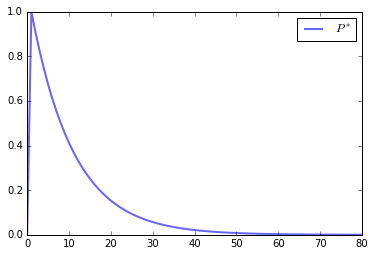

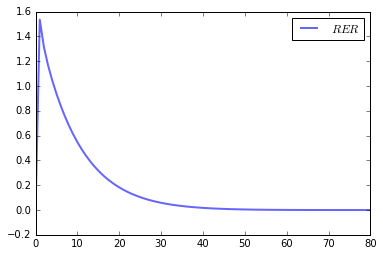

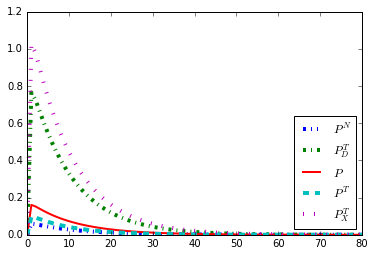

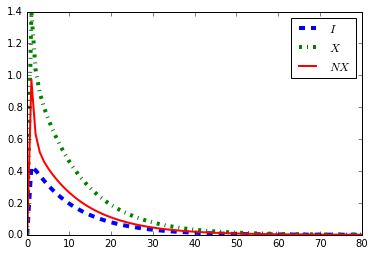

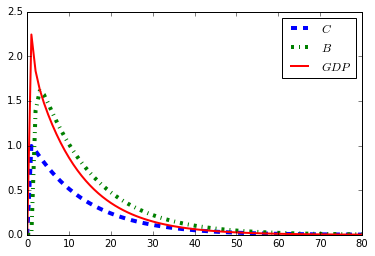

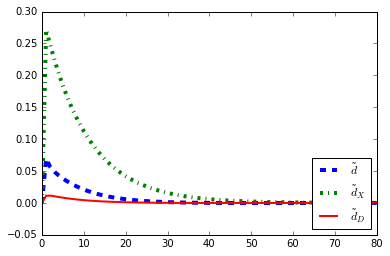

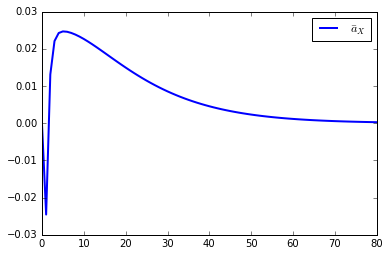

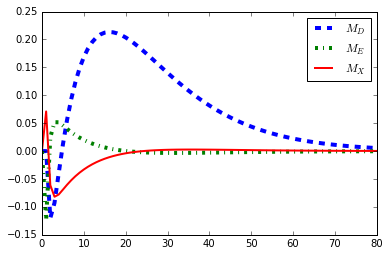

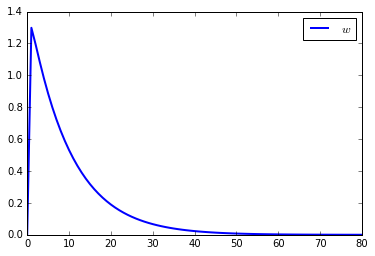

In [16]:
fig, plot_Pstar_Pstar = plt.subplots()
x = np.linspace(0, 80, 81)
plot_Pstar_Pstar.plot(x, rbc.irs['e_P_star']['P_star'], linewidth=2, linestyle='solid', alpha=0.6, label=r'$P^*$')
plot_Pstar_Pstar.legend()
plt.savefig('plot_Pstar_Pstar.png')

fig, plot_RER_Pstar = plt.subplots()
plot_RER_Pstar.plot(x, rbc.irs['e_P_star']['RER'], linewidth=2, linestyle='solid', alpha=0.6, label=r'$RER$')
plot_RER_Pstar.legend()
plt.savefig('plot_RER_Pstar.png')

fig, plot_P_Pstar = plt.subplots()
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_N'], linewidth=4, linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha=1, label='$P^N$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_TD'], linewidth=4, linestyle='dashdot', alpha=1, label='$P^T_D$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P'], linewidth=2, linestyle='solid', alpha=1, label='$P$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_T'], linewidth=4, linestyle='dashed', alpha=1, label='$P^T$')
plot_P_Pstar.plot(x, rbc.irs['e_P_star']['P_x'], linewidth=4, linestyle=(0, (1, 10)), alpha=1, label='$P_X^T$')
plot_P_Pstar.legend(loc='lower right')
plt.savefig('plot_P_Pstar.png')

fig, plot_NX_Pstar = plt.subplots()
plot_NX_Pstar.plot(x, rbc.irs['e_P_star']['I'], linewidth=4, linestyle='dashed', alpha=1, label='$I$')
plot_NX_Pstar.plot(x, rbc.irs['e_P_star']['X'], linewidth=4, linestyle='dashdot', alpha=1, label='$X$')
plot_NX_Pstar.plot(x, rbc.irs['e_P_star']['NX'], linewidth=2, linestyle='solid', alpha=1, label='$NX$')
plot_NX_Pstar.legend()
plt.savefig('plot_NX_Pstar.png')

fig, plot_macro_Pstar = plt.subplots()
plot_macro_Pstar.plot(x, rbc.irs['e_P_star']['C'], linewidth=4, linestyle='dashed', alpha=1, label='$C$')
plot_macro_Pstar.plot(x, rbc.irs['e_P_star']['B'], linewidth=4, linestyle='dashdot', alpha=1, label='$B$')
plot_macro_Pstar.plot(x, rbc.irs['e_P_star']['GDP'], linewidth=2, linestyle='solid', alpha=1, label='$GDP$')
plot_macro_Pstar.legend()
plt.savefig('plot_macro_Pstar.png')

fig, plot_d_P_star = plt.subplots()
plot_d_P_star.plot(x, rbc.irs['e_P_star']['d_tilde'], linewidth=4, linestyle='dashed', alpha=1, label=r'$\tilde{d}$')
plot_d_P_star.plot(x, rbc.irs['e_P_star']['d_tilde_x'], linewidth=4, linestyle='dashdot', alpha=1, label=r'$\tilde{d}_X$')
plot_d_P_star.plot(x, rbc.irs['e_P_star']['d_tilde_d'], linewidth=2, linestyle='solid', alpha=1, label=r'$\tilde{d}_D$')
plot_d_P_star.legend(loc='lower right')
plt.savefig('plot_d_P_star.png')

fig, plot_abar_Pstar = plt.subplots()
plot_abar_Pstar.plot(x, rbc.irs['e_P_star']['a_bar_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$\bar{a}_X$')
plot_abar_Pstar.legend()
plt.savefig('plot_abar_Pstar.png')

fig, plot_M_Pstar = plt.subplots()
plot_M_Pstar.plot(x, rbc.irs['e_P_star']['M_d'], linewidth=4, linestyle='dashed', alpha=1, label=r'$M_D$')
plot_M_Pstar.plot(x, rbc.irs['e_P_star']['M_e'], linewidth=4, linestyle='dashdot', alpha=1, label=r'$M_E$')
plot_M_Pstar.plot(x, rbc.irs['e_P_star']['M_x'], linewidth=2, linestyle='solid', alpha=1, label=r'$M_X$')
plot_M_Pstar.legend()
plt.savefig('plot_M_Pstar.png')

fig, plot_w_Pstar = plt.subplots()
plot_w_Pstar.plot(x, rbc.irs['e_P_star']['w'], linewidth=2, linestyle='solid', alpha=1, label=r'$w$')
plot_w_Pstar.legend()
plt.savefig('plot_w_Pstar.png')